In [1]:
import sys

paths_to_add = ['/home/jovyan/work', '/home/jupyter/alpha_media_signal']

for p in paths_to_add:
    if p not in sys.path:
        sys.path.append(p)
        

CPython 3.7.9
IPython 7.19.0

numpy 1.19.4
pandas 1.1.4
torch 1.7.0
transformers 3.4.0


In [ ]:
import math
from pathlib import Path
from ams.services import file_services
from ams.services.twitter_service import balance_df
%load_ext autoreload

%autoreload 2

%reload_ext watermark

%watermark -v -p numpy,pandas,torch,transformers

In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from transformers import AdamW

from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'GeForce GTX 970'

In [7]:
from ams.config import constants

file_path = constants.TWITTER_TEXT_LABEL_TRAIN_PATH
df = pd.read_parquet(file_path)

df = df.sample(frac=.1)

df["npl_text"] = df["npl_text"].astype('str')

num_rows = df.shape[0]
train_num = math.ceil(num_rows * .98)

df = df.sort_values(by=["date"], ascending=True)

df_train = df.iloc[:train_num]
df_train = balance_df(df_train)
df_train = df_train.sort_values(by=["date"], ascending=True)
df_test = df.iloc[train_num:]
df_test = balance_df(df_test)
df_test = df_test.sort_values(by=["date"], ascending=True)

In [8]:
df_train.sample(10)

,f22_id,text,buy_sell
1340852,7061548141802896666,RT @jendeukiebabo: BLACKPINK SCHOOL Class Elec...,0
210198,-6676452524606462930,Check out Townhead Alston. Posted 1910 https:/...,1
815778,694424777754236834,15 bucks -------- RT if good deal | like if li...,1
726079,-395339481003766629,RT @GPHlIC: 2000s apple iMac g3 / iBook https:...,1
1496285,8951472720249049856,RT @HARUW00S: the only boy performance where w...,0
13138,-9064524891594402422,Halloween Party Treat Bag https://t.co/uef1xM3...,0
719496,-475171500344947582,@EliotETC We export 40min to 2 hour shows at m...,1
53555,-8576551148855660334,Schneider Electric will integrate #Fortinet's ...,1
1503122,9033225897521310249,@bigpIoopy this video is the peak all videos g...,1
446972,-3796615969759569759,Lululemon Athletica $LULU Upgraded at BidaskCl...,1


In [9]:
tweets = df_train.nlp_text.values

In [10]:
tweets = [tweet + " [SEP] [CLS]" for tweet in tweets]
labels = df_train.buy_sell.values

In [11]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=True)

tokenized_texts = [tokenizer.tokenize(sent) for sent in tweets]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁', 'rt', '▁', '@', 'crystal', 'moon', '1', 'ba', ':', '▁ends', '▁10', '/', '05', ':', '▁for', '▁sale', '▁', '/', '▁best', '▁offer', '▁', '-', '▁', '#', 'amazon', 'ite', '▁', '#', 'car', 'ne', 'lian', '▁', '#', 'ster', 'ling', 'silver', '▁', '#', 'wire', 'wrapped', '▁', '#', 'cha', 'kra', '▁', '#', 're', 'iki', 'he', 'al', 'ing', '▁', '#', 'he', 'al', 'ing', 'p', '.', '.', '.', '▁[', 's', 'ep', ']', '▁[', 'cl', 's', ']']


In [12]:
# Set the maximum sequence length. The longest sequence in our training set is 47, but we'll leave room on the end anyway. 
MAX_LEN = 280

In [13]:
# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [14]:
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [15]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [16]:
# Use train_test_split to split our data into train and validation sets for training

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=2018, test_size=0.1)

In [17]:
# Convert all of our data into torch tensors, the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [18]:
# Select a batch size for training. For fine-tuning with XLNet, the authors recommend a batch size of 32, 48, or 128. We will use 32 here to avoid memory issues.
batch_size = 16

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
model = XLNetForSequenceClassification.from_pretrained("xlnet-base-cased", num_labels=2, mem_len=1024)
model.cuda()

C:\Users\Chris\AppData\Roaming\Python\Python37\site-packages\transformers\configuration_xlnet.py:212: FutureWarning: This config doesn't use attention memories, a core feature of XLNet. Consider setting `mem_len` to a non-zero value, for example `xlnet = XLNetLMHeadModel.from_pretrained('xlnet-base-cased'', mem_len=1024)`, for accurate training performance as well as an order of magnitude faster inference. Starting from version 3.5.0, the default parameter will be 1024, following the implementation in https://arxiv.org/abs/1906.08237
  FutureWarning,
Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are init

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [20]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [21]:
# This variable contains all of the hyperparemeter information our training loop needs
optimizer = AdamW(optimizer_grouped_parameters, lr=2e-5)

In [22]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    b_input_ids= b_input_ids.type(torch.LongTensor)
    b_input_mask= b_input_mask.type(torch.LongTensor)
    b_labels= b_labels.type(torch.LongTensor)
    
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)
    b_labels = b_labels.to(device)
    
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs[0]
    logits = outputs[1]
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    b_input_ids= b_input_ids.type(torch.LongTensor)
    b_input_mask= b_input_mask.type(torch.LongTensor)
    b_labels= b_labels.type(torch.LongTensor)
    
    b_input_ids = b_input_ids.to(device)
    b_input_mask = b_input_mask.to(device)
    b_labels = b_labels.to(device)
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = output[0]
    
    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 230.00 MiB (GPU 0; 4.00 GiB total capacity; 2.63 GiB already allocated; 117.72 MiB free; 2.73 GiB reserved in total by PyTorch)

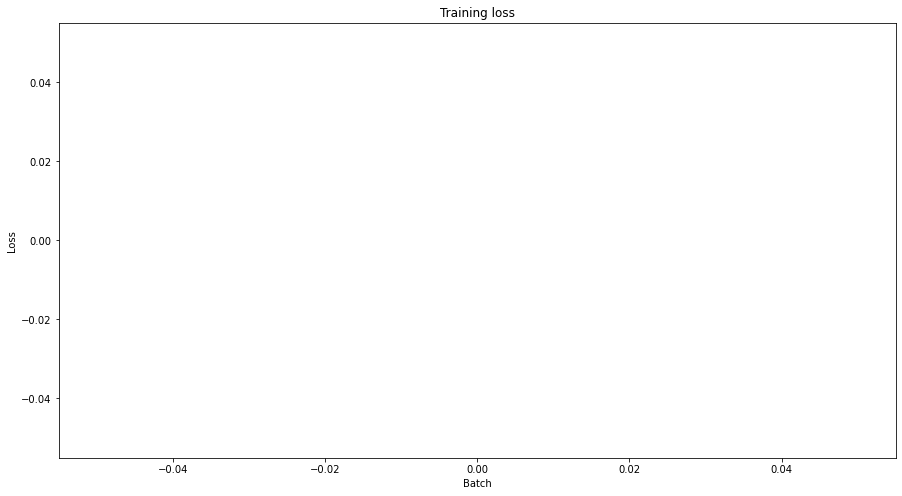

In [30]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [32]:
# file_path = constants.COLA_OUT_OF_DOMAIN_DEV_PATH
# df = pd.read_csv(file_path, delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])


# Create sentence and label lists
tweets = df_test.text.values

# We need to add special tokens at the beginning and end of each sentence for XLNet to work properly
tweets = [tweet + " [SEP] [CLS]" for tweet in tweets]
labels = df_test.buy_sell.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in tweets]

MAX_LEN = 128

# Use the XLNet tokenizer to convert the tokens to their index numbers in the XLNet vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  

prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [33]:
# Prediction on test set

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  # Telling the model not to compute or store gradients, saving memory and speeding up prediction
  with torch.no_grad():
    # Forward pass, calculate logit predictions
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

RuntimeError: Expected tensor for argument #1 'indices' to have scalar type Long; but got torch.cuda.IntTensor instead (while checking arguments for embedding)

In [ ]:
# Import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                 np.argmax(predictions[i], axis=1).flatten())
  matthews_set.append(matthews)

In [ ]:
# Flatten the predictions and true values for aggregate Matthew's evaluation on the whole dataset
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]

In [ ]:
matthews_corrcoef(flat_true_labels, flat_predictions)

In [ ]:
accuracy = flat_accuracy(predictions, true_labels)

print(f"Test accuracy: {accuracy}")

In [ ]:
model_path = file_services.create_unique_filename(parent_dir=constants.TWITTER_MODEL_PATH, prefix="xlnet-sent", extension="mod")

# https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model.state_dict(), model_path)
